In [2]:
import pandas as pd
import os
import csv

# Move the TPC

In [37]:
import os
import shutil
import pandas as pd

# Load the games.csv file
games_csv = pd.read_csv('./data/games.csv')

# Iterate through the rows
for index, row in games_csv.iterrows():
    gameId = row['gameId']
    homeTeamAbbr = row['homeTeamAbbr']
    visitorTeamAbbr = row['visitorTeamAbbr']

    if index < 100:
        # Define the directory path
        directory = f'./games/{gameId}_{homeTeamAbbr}_{visitorTeamAbbr}'

        # Check if the directory exists
        if os.path.exists(directory):
            # Iterate through subdirectories (playId folders)
            for subdir, _, files in os.walk(directory):
                for file in files:
                    # Check if the file is "tpc_weighted_blockers.csv"
                    if file == "tpc_weighted_blockers.csv":
                        # Define the source and destination paths
                        source_path = os.path.join(subdir, file)
                        destination_path = f'./tpc/tpc_weighted_blockers_{gameId}_{os.path.basename(subdir)}.csv'

                        # Move and rename the file
                        shutil.move(source_path, destination_path)
                        print(f'Moved: {source_path} -> {destination_path}')


# Build the CPR

In [3]:
def build_cpr(a:bool, b:bool, c:bool, d:bool):
    """
    Build the constrictive presence ratio CSV
    a: weighted_blockers
    b: weighted_no_blockers
    c: unweighted_blockers
    d: unweighted_no_blockers
    """    
    # Read the 'eval_frame_df.csv' file
    eval_frame_df = pd.read_csv(f'./data/eval_frame_df_old.csv')
    finished = set()

    # Iterate through rows of 'eval_frame_df'
    for _, row in eval_frame_df.iterrows():
        gameId = int(row['gameId'])
        playId = int(row['playId'])
        if (gameId, playId) in finished: 
            continue
        
        # Look up the game in 'games.csv'
        games_df = pd.read_csv('./data/games.csv')
        game_info = games_df[(games_df['gameId'] == gameId)]

        if game_info.empty:
            print(f"No game found for gameId: {gameId}")
            continue

        homeTeamAbbr = game_info['homeTeamAbbr'].values[0]
        visitingTeamAbbr = game_info['visitorTeamAbbr'].values[0]

        # Define the folder path
        folder_path = f'./games/{gameId}_{homeTeamAbbr}_{visitingTeamAbbr}/{playId}/'

        # Check if the folder exists and if the file exists
        if not os.path.exists(folder_path):
            print(f"Folder not found for gameId: {folder_path}")
            finished.add((gameId, playId))
            continue

        print(gameId, playId)

        if a: 
            weighted_blockers = os.path.join(folder_path, 'tpc_per_frame_weighted_blockers.csv')
        if b:
            weighted_no_blockers = os.path.join(folder_path, 'tpc_per_frame_weighted_no_blockers.csv')
        if c: 
            unweighted_no_blockers = os.path.join(folder_path, 'tpc_per_frame_unweighted_no_blockers.csv')
        if d: 
            unweighted_blockers = os.path.join(folder_path, 'tpc_per_frame_unweighted.csv')

        # if not os.path.exists(weighted_no_blockers):
        if not (os.path.exists(weighted_blockers) and os.path.exists(weighted_no_blockers)):
            print(f"File not found for gameId: {gameId}, {playId}")
            print(weighted_blockers)
            finished.add((gameId, playId))
            continue

        # Read 'tpc_per_frame_weighted_blockers.csv'
        if a: 
            try:
                tpc_per_frame_weighted_blockers = pd.read_csv(weighted_blockers, index_col=0)
                tpc_per_frame_weighted_blockers = tpc_per_frame_weighted_blockers.fillna(0)
                # if tpc_per_frame_weighted_blockers.isna().any().any():
                #     print('found nan')
                #     continue
            except:
                continue
        if b: 
            try:
                tpc_per_frame_weighted_no_blockers = pd.read_csv(weighted_no_blockers, index_col=0)
                tpc_per_frame_weighted_no_blockers = tpc_per_frame_weighted_no_blockers.fillna(0)
                # if tpc_per_frame_weighted_no_blockers.isna().any().any():
                #     print('found nan')
                #     continue
            except:
                continue
        if c: 
            tpc_per_frame_unweighted_blockers = pd.read_csv(unweighted_blockers, index_col=0)
            tpc_per_frame_unweighted_blockers = tpc_per_frame_unweighted_blockers.fillna(0)
        if d: 
            tpc_per_frame_unweighted_no_blockers = pd.read_csv(unweighted_no_blockers, index_col=0)
            tpc_per_frame_unweighted_no_blockers = tpc_per_frame_unweighted_no_blockers.fillna(0)

        # Sort 'eval_frame_df' by matching gameId and playId and sort it in order of frameId
        sorted_eval_frame_df = eval_frame_df[(eval_frame_df['gameId'] == gameId) & (eval_frame_df['playId'] == playId)].sort_values(by='frameId')
        filtered_eval_frame_df = sorted_eval_frame_df[sorted_eval_frame_df['frameId'].isin(tpc_per_frame_weighted_no_blockers.index)]
        ######### DEBUG #########################
        # print(filtered_eval_frame_df.index)

        # Calculate the product
        expected_yards_diff = filtered_eval_frame_df['expectedYardsByCarrier'].diff(-1).fillna(0)
        expected_yards_diff.index = tpc_per_frame_weighted_blockers.index

        # Check if the length of expected_yards_diff is the same as the number of rows in tpc_per_frame_weighted_blockers
        if (len(expected_yards_diff) == len(tpc_per_frame_weighted_blockers)) and (len(expected_yards_diff) == len(tpc_per_frame_weighted_no_blockers)):
            # Multiply each entry in the corresponding row by the value in expected_yards_diff
            if a: 
                cpr_weighted_blockers = tpc_per_frame_weighted_blockers.multiply(expected_yards_diff, axis=0)
            if b: 
                cpr_weighted_no_blockers = tpc_per_frame_weighted_no_blockers.multiply(expected_yards_diff, axis=0)
            if c: 
                cpr_unweighted_blockers = tpc_per_frame_unweighted_blockers.multiply(expected_yards_diff, axis=0)
            if d: 
                cpr_unweighted_no_blockers = tpc_per_frame_unweighted_no_blockers.multiply(expected_yards_diff, axis=0)
        else:
            # Print the shapes of both dataframes
            print(f"Shapes do not match - expected_yards_diff shape: {len(expected_yards_diff)}, tpc_per_frame_weighted_blockers shape: {len(tpc_per_frame_weighted_blockers)}")
            finished.add((gameId, playId))

        if a:
            cpr_weighted_blockers.to_csv(os.path.join(folder_path, 'cpr_weighted_blockers.csv'))
        if b: 
            cpr_weighted_no_blockers.to_csv(os.path.join(folder_path, 'cpr_weighted_no_blockers.csv'))
        if c: 
            cpr_unweighted_blockers.to_csv(os.path.join(folder_path, 'cpr_unweighted_blockers.csv'))
        if d: 
            cpr_unweighted_no_blockers.to_csv(os.path.join(folder_path, 'cpr_unweighted_no_blockers.csv'))

        finished.add((gameId, playId))

        print(f'success for {gameId}, {playId}')


In [4]:
build_cpr(a=True, b=True, c=False, d=False)
# build_cpr_no_nan(a=True, b=True, c=False, d=False)

2022092200 56
success for 2022092200, 56
2022092200 84
success for 2022092200, 84
2022092200 127
success for 2022092200, 127
2022092200 190
success for 2022092200, 190
2022092200 214
success for 2022092200, 214
2022092200 240
success for 2022092200, 240
2022092200 302
success for 2022092200, 302
2022092200 419
success for 2022092200, 419
2022092200 440
success for 2022092200, 440
2022092200 465
success for 2022092200, 465
2022092200 489
success for 2022092200, 489
2022092200 534
success for 2022092200, 534
2022092200 577
success for 2022092200, 577
2022092200 601
success for 2022092200, 601
2022092200 622
success for 2022092200, 622
2022092200 643
success for 2022092200, 643
2022092200 666
success for 2022092200, 666
2022092200 722
success for 2022092200, 722
2022092200 746
success for 2022092200, 746
2022092200 770
success for 2022092200, 770
2022092200 791
success for 2022092200, 791
2022092200 847
success for 2022092200, 847
2022092200 887
success for 2022092200, 887
2022092200 958


In [287]:
###### aggregate all players into one df
# Define the path to the 'games' folder and the output file
games_folder = './games'
weighted_blockers_output_file = './data/cpr_weighted_blockers.csv'
weighted_no_blockers_output_file = './data/cpr_weighted_no_blockers.csv'
eval_frame_df = pd.read_csv(f'./data/eval_frame_df.csv')
# Ensure the output directory exists
os.makedirs(os.path.dirname(weighted_blockers_output_file), exist_ok=True)
os.makedirs(os.path.dirname(weighted_no_blockers_output_file), exist_ok=True)

# Open the CSV file for writing
finished = set()

with open(weighted_blockers_output_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)

    # Write the header row
    writer.writerow(['gameId', 'playId', 'nflId', 'constrictivePresenceSum'])

    # iterate over the eval_frame_df
    for _, row in eval_frame_df.iterrows():
        gameId = int(row['gameId'])
        playId = int(row['playId'])
        if (gameId, playId) in finished: 
            continue
        
        # Look up the game in 'games.csv'
        games_df = pd.read_csv('./data/games.csv')
        game_info = games_df[(games_df['gameId'] == gameId)]

        # number = game_info.index[0]
        # if number < 100: 
        #     continue

        if game_info.empty:
            print(f"No game found for gameId: {gameId}")
            continue

        homeTeamAbbr = game_info['homeTeamAbbr'].values[0]
        visitingTeamAbbr = game_info['visitorTeamAbbr'].values[0]

        # Define the folder path
        folder_path = f'./games/{gameId}_{homeTeamAbbr}_{visitingTeamAbbr}/{playId}/'
        try: 
            weighted_blockers_filepath = os.path.join(folder_path, 'cpr_weighted_blockers.csv')
            weighted_blockers_df = pd.read_csv(weighted_blockers_filepath, index_col=0)
        except: 
            print(f"No file found at {folder_path}")
            finished.add((gameId, playId))
            continue

        # Calculate the sum of each column (player)
        player_sums = weighted_blockers_df.sum()

        # Write each player's sum to the CSV file
        for playerId, sum_value in player_sums.items():
            writer.writerow([gameId, playId, int(playerId), sum_value])

    finished.add((gameId, playId))

finished = set()
# Open the CSV file for writing
with open(weighted_no_blockers_output_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)

    # Write the header row
    writer.writerow(['gameId', 'playId', 'nflId', 'constrictivePresenceSum'])

    # iterate over the eval_frame_df
    for _, row in eval_frame_df.iterrows():
        gameId = int(row['gameId'])
        playId = int(row['playId'])
        if (gameId, playId) in finished: 
            continue
        
        # Look up the game in 'games.csv'
        games_df = pd.read_csv('./data/games.csv')
        game_info = games_df[(games_df['gameId'] == gameId)]

        # number = game_info.index[0]
        # if number < 100: 
        #     continue

        if game_info.empty:
            print(f"No game found for gameId: {gameId}")
            continue

        homeTeamAbbr = game_info['homeTeamAbbr'].values[0]
        visitingTeamAbbr = game_info['visitorTeamAbbr'].values[0]

        # Define the folder path
        folder_path = f'./games/{gameId}_{homeTeamAbbr}_{visitingTeamAbbr}/{playId}/'

        try: 
            weighted_no_blockers_filepath = os.path.join(folder_path, 'cpr_weighted_no_blockers.csv')
            weighted_no_blockers_df = pd.read_csv(weighted_no_blockers_filepath, index_col=0)
        except: 
            print(f"No file found at {folder_path}")
            finished.add((gameId, playId))
            continue

        # Calculate the sum of each column (player)
        player_sums = weighted_no_blockers_df.sum()

        # Write each player's sum to the CSV file
        for playerId, sum_value in player_sums.items():
            writer.writerow([gameId, playId, int(playerId), sum_value])

    finished.add((gameId, playId))

print("Aggregation complete. Data saved")

No file found at ./games/2022100900_GB_NYG/66/
No file found at ./games/2022100900_GB_NYG/615/
No file found at ./games/2022100900_GB_NYG/636/
No file found at ./games/2022100900_GB_NYG/660/
No file found at ./games/2022100900_GB_NYG/736/
No file found at ./games/2022100900_GB_NYG/801/
No file found at ./games/2022100900_GB_NYG/830/
No file found at ./games/2022100900_GB_NYG/851/
No file found at ./games/2022100900_GB_NYG/875/
No file found at ./games/2022100900_GB_NYG/934/
No file found at ./games/2022100901_BUF_PIT/96/
No file found at ./games/2022100901_BUF_PIT/117/
No file found at ./games/2022100901_BUF_PIT/193/
No file found at ./games/2022100901_BUF_PIT/222/
No file found at ./games/2022100901_BUF_PIT/254/
No file found at ./games/2022100901_BUF_PIT/320/
No file found at ./games/2022100901_BUF_PIT/344/
No file found at ./games/2022100901_BUF_PIT/365/
No file found at ./games/2022100901_BUF_PIT/394/
No file found at ./games/2022100901_BUF_PIT/418/
No file found at ./games/2022100

In [228]:
def augment_data_file(filename:str):
# augment with additional data like position and name

    # Load the players DataFrame
    players_file = './data/players.csv'
    players_df = pd.read_csv(players_file)

    # Load the constrictive presence ratio DataFrame
    constrictive_file = f'./data/{filename}'
    constrictive_df = pd.read_csv(constrictive_file)

    # Merge the DataFrames on nflId
    augmented_df = pd.merge(constrictive_df, players_df[['nflId', 'position', 'displayName']], 
                            on='nflId', how='left')

    # Save the augmented DataFrame
    augmented_df.to_csv(f'./data/{filename}', index=False)

    print(f"Augmentation complete. Data saved to './data/{filename}'")

In [229]:
# cpr_weighted_blockers_33_100 = pd.read_csv('./data/cpr_weighted_blockers_33-100.csv')
cpr_weighted_blockers_100_135 = pd.read_csv('./data/cpr_weighted_blockers_100-135.csv')
# cpr_weighted_blockers = pd.concat([cpr_weighted_blockers_33_100, cpr_weighted_blockers_100_135], axis=0)
cpr_weighted_blockers = cpr_weighted_blockers_100_135

In [230]:
# cpr_weighted_no_blockers_33_100 = pd.read_csv('./data/cpr_weighted_no_blockers_33-100.csv')
cpr_weighted_no_blockers_100_135 = pd.read_csv('./data/cpr_weighted_no_blockers_100-135.csv')
# cpr_weighted_no_blockers = pd.concat([cpr_weighted_no_blockers_33_100, cpr_weighted_no_blockers_100_135], axis=0)
cpr_weighted_no_blockers = cpr_weighted_no_blockers_100_135

In [231]:
cpr_weighted_blockers.to_csv('./data/cpr_weighted_blockers.csv')

In [232]:
cpr_weighted_no_blockers.to_csv('./data/cpr_weighted_no_blockers.csv')

In [233]:
augment_data_file('cpr_weighted_blockers.csv')

Augmentation complete. Data saved to './data/cpr_weighted_blockers.csv'


In [234]:
augment_data_file('cpr_weighted_no_blockers.csv')

Augmentation complete. Data saved to './data/cpr_weighted_no_blockers.csv'


In [236]:
def group_by_players(filename:str): 
    """ 
    Group the raw data by the players
    """
    # Load the constrictive_presence_ratio_all DataFrame
    constrictive_presence_ratio_all = pd.read_csv(f'./data/{filename}', index_col=0).drop_duplicates() # pd.read_csv(f'./data/{filename}').drop(columns=['Unnamed: 0']).drop_duplicates() # ???

    # Group by 'displayName' and sum 'constrictivePresenceSum'
    grouped_by_player = constrictive_presence_ratio_all[['nflId', 'displayName', 'position', 'constrictivePresenceSum']].groupby(['nflId', 'displayName', 'position']).sum()

    # Count the number of occurrences for each 'displayName'
    counts = constrictive_presence_ratio_all[['nflId', 'displayName', 'position']].value_counts()
    std_player = constrictive_presence_ratio_all[['nflId',  'displayName', 'position', 'constrictivePresenceSum']].groupby(['nflId', 'displayName', 'position']).std()

    # Divide the summed 'constrictivePresenceSum' by the count for each player
    grouped_by_player['counts'] = counts # - std_player.constrictivePresenceSum / counts
    grouped_by_player['std'] = std_player
    grouped_by_player['cpy_per_play'] = grouped_by_player.constrictivePresenceSum / grouped_by_player.counts

    grouped_by_player.to_csv(f'./data/per_player_{filename}', index=True)

In [237]:
group_by_players('cpr_weighted_blockers.csv')

In [238]:
group_by_players('cpr_weighted_no_blockers.csv')

In [239]:
cpr_weighted_no_blockers = pd.read_csv('./data/per_player_cpr_weighted_no_blockers.csv')
# cpr_weighted_no_blockers_filtered = cpr_weighted_no_blockers[cpr_weighted_blockers.counts > 2000]
cpr_weighted_no_blockers[cpr_weighted_no_blockers.counts > 25].sort_values('cpy_per_play', ascending=False).head(10)

nflId        displayName position  constrictivePresenceSum  counts  \
504  53445      Zaven Collins      OLB                22.993954      55   
112  43308        Shaq Lawson       DE                11.033286      29   
562  53601  Deommodore Lenoir       CB                22.446474      62   
300  46527       Frankie Luvu      ILB                28.887275      91   
258  46146        Sam Hubbard       DE                22.403168      71   
140  43409     David Onyemata       DT                18.735488      60   
65   41786        Kerry Hyder       DE                 8.956971      30   
457  52525        D.J. Wonnum      OLB                16.452499      56   
452  52510     Alex Highsmith      OLB                25.755238      92   
82   42401      Markus Golden      OLB                12.205258      45   

          std  cpy_per_play  
504  1.253505      0.418072  
112  1.026607      0.380458  
562  1.502908      0.362040  
300  0.991812      0.317443  
258  1.045921      0.315538  
140  1.540187      0.312258  
65   1.054361      0.298566  
457  1.011900      0.293795  
452  1.327872      0.279948  
82   1.039548      0.271228

In [245]:
cpr_weighted_blockers = pd.read_csv('./data/per_player_cpr_weighted_blockers.csv')
# cpr_weighted_blockers_filtered = cpr_weighted_blockers[cpr_weighted_blockers.counts > 3000]
cpr_weighted_blockers[cpr_weighted_blockers.counts > 25].sort_values('cpy_per_play', ascending=False).head(50)

nflId         displayName position  constrictivePresenceSum  counts  \
13   37097      Cameron Jordan       DE                36.366685      73   
596  54491    Jermaine Johnson       DE                12.236618      33   
285  46255         Jake Martin       DE                 9.505800      31   
440  52479    Justin Madubuike       DT                13.735779      48   
82   42401       Markus Golden      OLB                12.376027      45   
354  47877          Jamel Dean       CB                29.119903     106   
331  47809        Montez Sweat       DE                14.147206      52   
68   42031        Denico Autry       DE                14.976345      58   
525  53489         Pete Werner      OLB                20.297142      82   
561  53601   Deommodore Lenoir       CB                14.851012      62   
249  46132       Carlton Davis       CB                20.973011      90   
270  46188         Kyzir White      ILB                12.030351      52   
388  48032       Michael Dogbe       DE                 6.468747      28   
258  46146         Sam Hubbard       DE                15.247404      71   
137  43404  De'Vondre Campbell      ILB                26.552167     126   
163  44815      Solomon Thomas       DT                 6.693693      32   
126  43352         Adam Gotsis       DE                10.189242      49   
93   42465     Za'Darius Smith      OLB                12.865897      62   
605  54503     Arnold Ebiketie      OLB                 9.481828      49   
347  47855      Germaine Pratt      OLB                 6.328976      33   
550  53564       Rashad Weaver      OLB                10.901343      62   
50   41239        Aaron Donald       DT                14.806886      85   
367  47931        Dre Greenlaw      ILB                15.127722      89   
22   38544    Michael Brockers       DE                 5.489162      33   
83   42403       Randy Gregory       DE                 8.533206      52   
55   41270     Lamarcus Joyner       SS                14.246465      90   
63   41595         Mike Pennel       NT                 5.063296      32   
511  53459    Gregory Rousseau       DE                 6.998064      46   
332  47810     Johnathan Abram       SS                11.287687      75   
603  54500      Roger McCreary       CB                13.140263      88   
14   37104     Cameron Heyward       DT                10.414416      72   
118  43326         Chris Jones       DT                10.732737      75   
197  44911       Rasul Douglas       CB                14.276429     101   
325  47795         Rashan Gary      OLB                11.515386      87   
3    35454   Jason Pierre-Paul       DE                 3.948418      30   
113  43313     William Jackson       CB                 4.585336      35   
407  48544          Shy Tuttle       DT                 8.889879      68   
580  53674         Tre Norwood       FS                 4.035108      31   
486  52792    Tershawn Wharton       DT                 6.443493      52   
180  44867    Dalvin Tomlinson       DT                 9.542225      78   
282  46232          Tim Settle       DT                 5.866141      48   
456  52525         D.J. Wonnum      OLB                 6.578077      56   
396  48259       Darius Harris      ILB                 6.627440      57   
415  52416      Isaiah Simmons       DB                 4.166718      36   
576  53642    Rachad Wildgoose       CB                 3.325966      29   
473  52624         Kamren Curl       SS                 8.119578      71   
300  46527        Frankie Luvu      ILB                10.087227      91   
21   38542        Fletcher Cox       DT                 4.530723      41   
261  46153        Justin Jones       DT                 5.832154      53   
1    35449        Tyson Alualu       NT                 4.770182      44   

          std  cpy_per_play  
13   1.750902      0.498174  
596  1.398673      0.370807  
285  1.039048      0.306639  
440  1.3

In [286]:
# cpr_weighted_blockers[(cpr_weighted_blockers.counts >= 50) & (cpr_weighted_blockers.position == 'DE')].sort_values('cpy_per_play', ascending=False).shape
cpr_weighted_blockers[(cpr_weighted_blockers.counts >= 0) & (cpr_weighted_blockers.position == 'DE')].sort_values('cpy_per_play', ascending=False).head(50)

nflId         displayName position  constrictivePresenceSum  counts  \
28   38589         Vinny Curry       DE                 4.736592       1   
535  53508      Malcolm Koonce       DE                 4.044568       6   
13   37097      Cameron Jordan       DE                36.366685      73   
476  52641       Casey Toohill       DE                 5.774249      15   
596  54491    Jermaine Johnson       DE                12.236618      33   
406  48537     Carl Granderson       DE                 4.465492      14   
285  46255         Jake Martin       DE                 9.505800      31   
331  47809        Montez Sweat       DE                14.147206      52   
68   42031        Denico Autry       DE                14.976345      58   
526  53490       Carlos Basham       DE                 4.324024      18   
388  48032       Michael Dogbe       DE                 6.468747      28   
281  46229  Ogbonnia Okoronkwo       DE                 5.149194      23   
89   42436      Henry Anderson       DE                 5.493161      25   
258  46146         Sam Hubbard       DE                15.247404      71   
339  47832          Ben Banogu       DE                 2.739076      13   
398  48308     Jonathan Kongbo       DE                 3.979174      19   
126  43352         Adam Gotsis       DE                10.189242      49   
633  54582     Micheal Clemons       DE                 4.082448      23   
22   38544    Michael Brockers       DE                 5.489162      33   
83   42403       Randy Gregory       DE                 8.533206      52   
511  53459    Gregory Rousseau       DE                 6.998064      46   
3    35454   Jason Pierre-Paul       DE                 3.948418      30   
492  52952     Benning Potoa'e       DE                 0.394757       3   
509  53457       Payton Turner       DE                 2.946852      23   
655  54688       Isaiah Thomas       DE                 1.639305      13   
537  53513    Chauncey Golston       DE                 1.909760      16   
359  47889         Maxx Crosby       DE                 7.473321      70   
346  47854      Dre'Mont Jones       DE                10.624046     103   
552  53577      Ta'Quon Graham       DE                 6.673038      69   
131  43361    Jonathan Bullard       DE                 3.936141      43   
42   40074    William Gholston       DE                 5.234726      59   
321  47787      Clelin Ferrell       DE                 2.464129      28   
218  45038       Isaac Rochell       DE                 4.653354      53   
632  54581    Eyioma Uwazurike       DE                 0.890417      11   
645  54639  Dominique Robinson       DE                 2.023568      27   
130  43358     Yannick Ngakoue       DE                 5.496383      76   
65   41786         Kerry Hyder       DE                 1.870461      30   
11   37084           J.J. Watt       DE                 2.724305      49   
24   38551      Chandler Jones       DE                 3.323397      60   
70   42331           Efe Obada       DE                 2.059824      41   
414  52415       Derrick Brown       DE                 3.749727      75   
0    33131     Calais Campbell       DE                 2.999164      61   
162  44813       Myles Garrett       DE                 1.575832      37   
313  46771   Abdullah Anderson       DE                 1.119427      28   
112  43308         Shaq Lawson       DE                 1.011375      29   
61   41464       Shelby Harris       DE                 0.500112      19   
666  55016   Kingsley Jonathan       DE                 0.043681       2   
621  54549       DeMarvin Leal       DE                 0.583668      28   
490  52873      Delontae Scott       DE                 0.145489       8   
393  48170     Jonathan Harris       DE                 0.269138      18   

          std  cpy_per_play  
28        NaN      4.736592  
535  1.126531      0.674095  
13   1.750902      0.498174  
476  0.6

In [219]:
per_play_cpr_weighted_no_blockers = pd.read_csv('./data/cpr_weighted_no_blockers.csv').drop(columns=['Unnamed: 0']).drop_duplicates() # ???
per_play_cpr_weighted_blockers = pd.read_csv('./data/cpr_weighted_blockers.csv').drop(columns=['Unnamed: 0']).drop_duplicates() # ???
per_play_cpr_weighted_no_blockers.head(5)

gameId  playId  nflId  constrictivePresenceSum position  \
0  2022092200      56  35449                -0.074380       NT   
1  2022092200      56  37104                 0.466464       DT   
2  2022092200      56  43325                -0.097304      ILB   
3  2022092200      56  44877                -0.196185       DT   
4  2022092200      56  44878                -1.236932       CB   

           displayName  
0         Tyson Alualu  
1      Cameron Heyward  
2           Myles Jack  
3       Larry Ogunjobi  
4  Ahkello Witherspoon

(65, 6)
constrictivePresenceSum   -29.455721
dtype: float64


gameId  playId  nflId  constrictivePresenceSum position  \
177697  2022092505    2441  43435                -5.630273      OLB   
171856  2022092505    1527  43435                -4.955133      OLB   
170711  2022092505    1451  43435                -4.295048      OLB   
727398  2022100211    2949  43435                -4.005222      OLB   
731997  2022100211    3868  43435                -3.178698      OLB   
162990  2022092505     327  43435                -2.563616      OLB   
718676  2022100211    1923  43435                -2.555962      OLB   
176387  2022092505    2184  43435                -2.420520      OLB   
709039  2022100211     547  43435                -1.943894      OLB   
710459  2022100211     798  43435                -1.505133      OLB   

       displayName  
177697  Matt Judon  
171856  Matt Judon  
170711  Matt Judon  
727398  Matt Judon  
731997  Matt Judon  
162990  Matt Judon  
718676  Matt Judon  
176387  Matt Judon  
709039  Matt Judon  
710459  Matt Judon

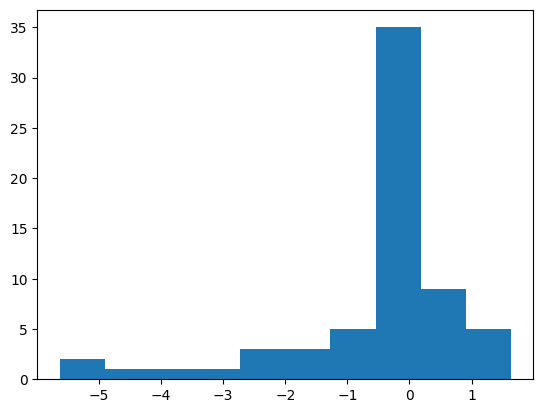

In [221]:
from matplotlib import pyplot as plt
import numpy as np

# player_df = per_play_cpr_weighted_blockers[per_play_cpr_weighted_blockers['displayName'] == 'Zaire Franklin']
player_df = per_play_cpr_weighted_blockers[per_play_cpr_weighted_blockers['displayName'] == 'Matt Judon']

print(player_df.shape)
print(np.sum(player_df[['constrictivePresenceSum']]))
plt.hist(player_df[['constrictivePresenceSum']])
player_df.sort_values('constrictivePresenceSum', ascending=True).head(10)

In [158]:
tackles_df = pd.read_csv('./data/tackles.csv')
players_df = pd.read_csv('./data/players.csv')
tackles_df = tackles_df.merge(players_df[['nflId', 'displayName', 'position']], on='nflId', how='left')
tackles_df.head(5)

gameId  playId  nflId  tackle  assist  forcedFumble  pff_missedTackle  \
0  2022090800     101  42816       1       0             0                 0   
1  2022090800     393  46232       1       0             0                 0   
2  2022090800     486  40166       1       0             0                 0   
3  2022090800     646  47939       1       0             0                 0   
4  2022090800     818  40107       1       0             0                 0   

      displayName position  
0       Troy Hill       CB  
1      Tim Settle       DT  
2    Jordan Poyer       SS  
3  Justin Hollins      OLB  
4      Micah Hyde       FS

In [190]:
tackles_by_player_df = tackles_df.groupby(['nflId', 'displayName', 'position']).sum()
tackles_by_player_df['overallTackles'] = tackles_by_player_df['tackle'] + 0.5 * tackles_by_player_df['assist'] - tackles_by_player_df['pff_missedTackle']
tackles_by_player_df = tackles_by_player_df.reset_index()
tackles_by_player_df[tackles_by_player_df['position'] == 'OLB'].sort_values('overallTackles', ascending=False).head(10)
# tackles_by_player_df[tackles_by_player_df['displayName'] == 'Adam Gotsis'].sort_values('overallTackles', ascending=False).head(10)

nflId           displayName position        gameId  playId  tackle  \
337  46304        Zaire Franklin      OLB  190077299706  187055      55   
606  53489           Pete Werner      OLB  163789934473  161197      51   
617  53509         Divine Deablo      OLB  159745724209  158275      39   
278  46088  Leighton Vander Esch      OLB  125370115908   98436      34   
129  42929        Alex Singleton      OLB  141546961172  165625      38   
263  45345       Nicholas Morrow      OLB  137502656771  132206      40   
584  53445         Zaven Collins      OLB  153679537766  147330      39   
70   41300     Christian Kirksey      OLB  121325949277  108520      34   
407  47855        Germaine Pratt      OLB  129414302267  128420      26   
417  47881       Quincy Williams      OLB  115259658573  107325      35   

     assist  forcedFumble  pff_missedTackle  overallTackles  
337      28             0                12            57.0  
606      22             2                 8            54.0  
617      34             0                 7            49.0  
278      25             1                 3            43.5  
129      24             0                 8            42.0  
263      19             0                10            39.5  
584      24             1                13            38.0  
70       20             0                 6            38.0  
407      31             0                 7            34.5  
417      13             0                 9            32.5

# EVERYTHING BELOW THIS IS IRRELEVANT

### Format

In [3]:
expected_yards = pd.read_csv('./data/eval_frame_df.csv')
expected_yards.head()

gameId  playId  ...  expectedRemainingYardsByCarrier  expectedYardsByCarrier
0  2022092200      56  ...                         4.692643                4.692643
1  2022092200      56  ...                         4.394129                4.444132
2  2022092200      56  ...                         4.390025                4.600024
3  2022092200      56  ...                         4.142516                4.602515
4  2022092200      56  ...                         4.147831                4.927829

[5 rows x 13 columns]

In [5]:
play = pd.read_csv('./games/2022090800_LA_BUF/56/tpc_per_frame_unweighted.csv', index_col=0)
play.head()

38577  41239  42816     43294  ...     47917  48026  52607   53532
6   1.8407    0.0    0.0  197.6369  ...  246.0608    0.0    0.0  7.1840
7   2.6687    0.0    0.0  197.7528  ...  227.5581    0.0    0.0  6.7180
8   3.5493   -0.0    0.0  197.1863  ...  207.6185   -0.0    0.0  5.5805
9   4.4418    0.0    0.0  196.1758  ...  185.4501    0.0    0.0  4.2674
10  5.1009    0.0    0.0  194.1843  ...  159.3285    0.0    0.0  3.0750

[5 rows x 11 columns]

## Unweighted with Blockers Results

### Calculate results

In [47]:
######## This iterates through the tpc files, normalizes each frame to sum to one, and multiplies each row by the expected yards_{frame+1} - expected_yards_{frame}
# read in expected yards data
expected_yards = pd.read_csv('./data/eval_frame_df.csv')
# Define the path to the 'games' folder
games_folder = './games'

# Iterate over each game folder
for game_folder in os.listdir(games_folder):
    game_path = os.path.join(games_folder, game_folder)
    if os.path.isdir(game_path):
        # Extract gameId from the folder name
        gameId = int(game_folder.split('_')[0])
        print(gameId)

        # Iterate over each play folder within the game folder
        for play_folder in os.listdir(game_path):
            play_path = os.path.join(game_path, play_folder)
            if os.path.isdir(play_path):
                # Extract playId from the folder name
                playId = int(play_folder)

                # Define the path to the tpc_per_frame_unweighted.csv file
                unweigted_blockers = os.path.join(play_path, 'tpc_per_frame_unweighted.csv')
                if os.path.exists(tpc_file_path):
                    # Load the tpc_per_frame_unweighted DataFrame
                    tpc_df = pd.read_csv(tpc_file_path, index_col=0)

                    # Normalize each row so that it sums to 1
                    tpc_df = tpc_df.div(tpc_df.sum(axis=1), axis=0)

                    # Filter the expected_yards DataFrame for the current gameId and playId
                    filtered_expected_yards = expected_yards[(expected_yards['gameId'] == gameId) & 
                                                             (expected_yards['playId'] == playId)]

                    # Initialize a DataFrame to store the results
                    constrictive_presence_ratio_df = pd.DataFrame(index=tpc_df.index, columns=tpc_df.columns)

                    # Iterate through the rows
                    for frame in tpc_df.index:
                        # Ensure the frame exists in the filtered_expected_yards
                        if frame in filtered_expected_yards['frameId'].values:
                            # Calculate the difference in expected yards for each frame
                            current_frame_row = filtered_expected_yards[filtered_expected_yards['frameId'] == frame]
                            next_frame_row = filtered_expected_yards[filtered_expected_yards['frameId'] == frame + 1]
                            if not next_frame_row.empty:
                                delta_expected_yards = current_frame_row['expectedYardsByCarrier'].values[0]- next_frame_row['expectedYardsByCarrier'].values[0]
                                # Multiply the percentages for each player by the delta
                                # print(tpc_df.loc[frame])
                                # print(delta_expected_yards)
                                # print(tpc_df.loc[frame] * delta_expected_yards)
                                constrictive_presence_ratio_df.loc[frame,:] = tpc_df.loc[frame,:] * delta_expected_yards

                    # Save the resulting DataFrame
                    # print(constrictive_presence_ratio_df)
                    constrictive_presence_ratio_df.to_csv(os.path.join(play_path, 'constrictive_presence_ratio_unweighted.csv'))

2022110604
2022100204
2022092501
2022100900
2022091812
2022103008
2022091105
2022100910
2022102303
2022110700
2022110607
2022092507
2022102400
2022100908
2022092900
2022091107
2022091500
2022102310
2022091803
2022100205
2022092513
2022101700
2022102700
2022092512
2022100905
2022091802
2022091113
2022091901
2022102304
2022100212
2022101602
2022103100
2022103009
2022100903
2022110603
2022110600
2022091200
2022090800
2022100600
2022091100
2022091101
2022091800
2022092500
2022102308
2022103001
2022092600
2022110601
2022100202
2022100210
2022091805
2022100206
2022091110
2022100211
2022091804
2022103007
2022110605
2022091806
2022103002
2022100208
2022101603
2022091809
2022091108
2022091104
2022110606
2022100904
2022092504
2022092510
2022100209
2022092509
2022091900
2022103004
2022101601
2022102307
2022102309
2022110608
2022092511
2022100911
2022092505
2022102305
2022091103
2022092502
2022092200
2022091811
2022101600
2022101611
2022101609
2022102302
2022102311
2022110300
2022110610
2022092508

In [48]:
###### aggregate all players into one df
# Define the path to the 'games' folder and the output file
games_folder = './games'
output_file = './data/constrictive_presence_ratio_unweighted.csv'
counter = 0
# Ensure the output directory exists
os.makedirs(os.path.dirname(output_file), exist_ok=True)

# Open the CSV file for writing
with open(output_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)

    # Write the header row
    writer.writerow(['gameId', 'playId', 'nflId', 'constrictivePresenceSum'])

    # Iterate over each game folder
    for game_folder in os.listdir(games_folder):
        game_path = os.path.join(games_folder, game_folder)
        if os.path.isdir(game_path):
            # Extract gameId from the folder name
            gameId = int(game_folder.split('_')[0])
            print(f'Game: {gameId}, counter: {counter}')
            counter+=1

            # Iterate over each play folder within the game folder
            for play_folder in os.listdir(game_path):
                play_path = os.path.join(game_path, play_folder)
                if os.path.isdir(play_path):
                    # Extract playId from the folder name
                    playId = int(play_folder)

                    # Define the path to the constrictive_presence_ratio_unweighted.csv file
                    constrictive_file_path = os.path.join(play_path, 'constrictive_presence_ratio_unweighted.csv')
                    if os.path.exists(constrictive_file_path):
                    
                        # Load the constrictive_presence_ratio_unweighted DataFrame
                        constrictive_df = pd.read_csv(constrictive_file_path, index_col=0)

                        # Calculate the sum of each column (player)
                        player_sums = constrictive_df.sum()

                        # Write each player's sum to the CSV file
                        for playerId, sum_value in player_sums.items():
                            writer.writerow([gameId, playId, playerId, sum_value])

print("Aggregation complete. Data saved to", output_file)


Game: 2022110604, counter: 0
Game: 2022100204, counter: 1
Game: 2022092501, counter: 2
Game: 2022100900, counter: 3
Game: 2022091812, counter: 4
Game: 2022103008, counter: 5
Game: 2022091105, counter: 6
Game: 2022100910, counter: 7
Game: 2022102303, counter: 8
Game: 2022110700, counter: 9
Game: 2022110607, counter: 10
Game: 2022092507, counter: 11
Game: 2022102400, counter: 12
Game: 2022100908, counter: 13
Game: 2022092900, counter: 14
Game: 2022091107, counter: 15
Game: 2022091500, counter: 16
Game: 2022102310, counter: 17
Game: 2022091803, counter: 18
Game: 2022100205, counter: 19
Game: 2022092513, counter: 20
Game: 2022101700, counter: 21
Game: 2022102700, counter: 22
Game: 2022092512, counter: 23
Game: 2022100905, counter: 24
Game: 2022091802, counter: 25
Game: 2022091113, counter: 26
Game: 2022091901, counter: 27
Game: 2022102304, counter: 28
Game: 2022100212, counter: 29
Game: 2022101602, counter: 30
Game: 2022103100, counter: 31
Game: 2022103009, counter: 32
Game: 2022100903, co

In [49]:
# augment with additional data like position and name

# Load the players DataFrame
players_file = './data/players.csv'
players_df = pd.read_csv(players_file)

# Load the constrictive presence ratio DataFrame
constrictive_file = './data/constrictive_presence_ratio_unweighted.csv'
constrictive_df = pd.read_csv(constrictive_file)

# Merge the DataFrames on nflId
augmented_df = pd.merge(constrictive_df, players_df[['nflId', 'position', 'displayName']], 
                        on='nflId', how='left')

# Save the augmented DataFrame
augmented_df.to_csv('./data/constrictive_presence_ratio_unweighted.csv', index=False)

print("Augmentation complete. Data saved to './data/constrictive_presence_ratio_unweighted.csv'")


Augmentation complete. Data saved to './data/constrictive_presence_ratio_unweighted.csv'


### Analyze results

In [86]:
# Load the constrictive_presence_ratio_all DataFrame
constrictive_presence_ratio_all = pd.read_csv('./data/constrictive_presence_ratio_unweighted.csv')

# Group by 'displayName' and sum 'constrictivePresenceSum'
grouped_by_player = constrictive_presence_ratio_all[['displayName', 'constrictivePresenceSum']].groupby('displayName').sum()

# Count the number of occurrences for each 'displayName'
counts = constrictive_presence_ratio_all['displayName'].value_counts()
std_player = constrictive_presence_ratio_all[['displayName', 'constrictivePresenceSum']].groupby('displayName').std()

# Divide the summed 'constrictivePresenceSum' by the count for each player
grouped_by_player['counts'] = counts # - std_player.constrictivePresenceSum / counts
grouped_by_player['std'] = std_player

grouped_by_player.to_csv('./data/cpr_per_player_unweighted.csv', index=True)



In [81]:
ranked_players = grouped_by_player.sort_values(by='adjustedPresenceSum', ascending=False)

# Print the names of the players in order
print("Ranked Players from Greatest to Lowest based on Constrictive Presence Sum, UNWEIGHTED, WITH BLOCKERS:")
ranked_players.head(50)

Ranked Players from Greatest to Lowest based on Constrictive Presence Sum, UNWEIGHTED, WITH BLOCKERS:


constrictivePresenceSum  adjustedPresenceSum
displayName                                                    
George Odum                      10.063278             2.515820
De'Shaan Dixon                    6.575982             2.191994
Antwaun Woods                    13.609986             1.944284
Jesse Luketa                     24.230432             1.863879
Kyron Johnson                    10.544266             1.757378
Zack Baun                        22.491661             1.730128
Jamie Collins                    27.088074             1.693005
Ryan Anderson                    19.778461             1.412747
Lamar Jackson                     2.799852             1.399926
Saivion Smith                     2.779130             1.389565
Vinny Curry                      59.116165             1.374795
Derrek Tuszka                    51.501049             1.287526
Arron Mosby                       1.282844             1.282844
Bruce Irvin                      60.199770             1.280846
Isaiah Thomas                    54.846799             1.246518
Patrick Johnson                  65.573484             1.237236
Kayvon Thibodeaux               164.382358             1.235958
Trayvon Mullen                   11.038543             1.226505
DeAngelo Malone                  56.875711             1.210122
Joshua Onujiogu                   5.930639             1.186128
Nick McCloud                     33.928470             1.169947
Tae Hayes                        25.055397             1.138882
Anfernee Jennings               109.195351             1.125725
Preston Smith                   266.957271             1.112322
Tomon Fox                        71.773429             1.104207
Ladarius Hamilton                12.118981             1.101726
Joe Bachie                        7.574032             1.082005
Kristian Welch                    3.201648             1.067216
Carl Nassib                      85.539366             1.056042
Dee Delaney                      53.820921             1.055312
Elijah Riley                      3.154955             1.051652
Jaelan Phillips                 222.692943             1.050438
Malcolm Koonce                   19.952770             1.050146
Boye Mafe                       133.061184             1.047726
Ben Stille                        5.197154             1.039431
T.Y. McGill                       4.141270             1.035318
Nik Bonitto                      77.125304             1.028337
D.J. Wonnum                     117.146090             1.018662
Carlos Davis                      4.044219             1.011055
Dayo Odeyingbo                  102.114713             1.011037
Tarron Jackson                   15.041618             1.002775
Will Parks                       16.865962             0.992115
Amare Barno                       8.796210             0.977357
Elerson Smith                     5.861900             0.976983
Trent McDuffie                   35.096349             0.974899
Isaac Rochell                    75.012754             0.974192
Matt Judon                      186.661841             0.967160
Justin Hollins                  142.241746             0.954643
Tyus Bowser                      15.267377             0.954211
Ben Banogu                       27.669968             0.954137

## Unweighted without Blockers Analysis 

### Calculation

In [55]:
######## This iterates through the tpc files, normalizes each frame to sum to one, and multiplies each row by the expected yards_{frame+1} - expected_yards_{frame}
# read in expected yards data
expected_yards = pd.read_csv('./data/eval_frame_df.csv')
# Define the path to the 'games' folder
games_folder = './games'

# Iterate over each game folder
for game_folder in os.listdir(games_folder):
    game_path = os.path.join(games_folder, game_folder)
    if os.path.isdir(game_path):
        # Extract gameId from the folder name
        gameId = int(game_folder.split('_')[0])
        print(gameId)

        # Iterate over each play folder within the game folder
        for play_folder in os.listdir(game_path):
            play_path = os.path.join(game_path, play_folder)
            if os.path.isdir(play_path):
                # Extract playId from the folder name
                playId = int(play_folder)

                # Define the path to the tpc_per_frame_unweighted.csv file
                tpc_file_path = os.path.join(play_path, 'tpc_per_frame_unweighted_no_blockers.csv')
                if os.path.exists(tpc_file_path):
                    # Load the tpc_per_frame_unweighted DataFrame
                    tpc_df = pd.read_csv(tpc_file_path, index_col=0)

                    # Normalize each row so that it sums to 1
                    tpc_df = tpc_df.div(tpc_df.sum(axis=1), axis=0)

                    # Filter the expected_yards DataFrame for the current gameId and playId
                    filtered_expected_yards = expected_yards[(expected_yards['gameId'] == gameId) & 
                                                             (expected_yards['playId'] == playId)]

                    # Initialize a DataFrame to store the results
                    constrictive_presence_ratio_df = pd.DataFrame(index=tpc_df.index, columns=tpc_df.columns)

                    # Iterate through the rows
                    for frame in tpc_df.index:
                        # Ensure the frame exists in the filtered_expected_yards
                        if frame in filtered_expected_yards['frameId'].values:
                            # Calculate the difference in expected yards for each frame
                            current_frame_row = filtered_expected_yards[filtered_expected_yards['frameId'] == frame]
                            next_frame_row = filtered_expected_yards[filtered_expected_yards['frameId'] == frame + 1]
                            if not next_frame_row.empty:
                                delta_expected_yards = current_frame_row['expectedYardsByCarrier'].values[0]- next_frame_row['expectYardsByCarrier'].values[0]
                                # Multiply the percentages for each player by the delta
                                # print(tpc_df.loc[frame])
                                # print(delta_expected_yards)
                                # print(tpc_df.loc[frame] * delta_expected_yards)
                                constrictive_presence_ratio_df.loc[frame,:] = tpc_df.loc[frame,:] * delta_expected_yards

                    # Save the resulting DataFrame
                    # print(constrictive_presence_ratio_df)
                    constrictive_presence_ratio_df.to_csv(os.path.join(play_path, 'constrictive_presence_ratio_unweighted_without_blockers.csv'))

2022110604
2022100204
2022092501
2022100900
2022091812
2022103008
2022091105
2022100910
2022102303
2022110700
2022110607
2022092507
2022102400
2022100908
2022092900
2022091107
2022091500
2022102310
2022091803
2022100205
2022092513
2022101700
2022102700
2022092512
2022100905
2022091802
2022091113
2022091901
2022102304
2022100212
2022101602
2022103100
2022103009
2022100903
2022110603
2022110600
2022091200
2022090800
2022100600
2022091100
2022091101
2022091800
2022092500
2022102308
2022103001
2022092600
2022110601
2022100202
2022100210
2022091805
2022100206
2022091110
2022100211
2022091804
2022103007
2022110605
2022091806
2022103002
2022100208
2022101603
2022091809
2022091108
2022091104
2022110606
2022100904
2022092504
2022092510
2022100209
2022092509
2022091900
2022103004
2022101601
2022102307
2022102309
2022110608
2022092511
2022100911
2022092505
2022102305
2022091103
2022092502
2022092200
2022091811
2022101600
2022101611
2022101609
2022102302
2022102311
2022110300
2022110610
2022092508

In [58]:
###### aggregate all players into one df
# Define the path to the 'games' folder and the output file
games_folder = './games'
output_file = './data/constrictive_presence_ratio_unweighted_without_blockers.csv'
counter = 0
# Ensure the output directory exists
os.makedirs(os.path.dirname(output_file), exist_ok=True)

# Open the CSV file for writing
with open(output_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)

    # Write the header row
    writer.writerow(['gameId', 'playId', 'nflId', 'constrictivePresenceSum'])

    # Iterate over each game folder
    for game_folder in os.listdir(games_folder):
        game_path = os.path.join(games_folder, game_folder)
        if os.path.isdir(game_path):
            # Extract gameId from the folder name
            gameId = int(game_folder.split('_')[0])
            print(f'Game: {gameId}, counter: {counter}')
            counter+=1

            # Iterate over each play folder within the game folder
            for play_folder in os.listdir(game_path):
                play_path = os.path.join(game_path, play_folder)
                if os.path.isdir(play_path):
                    # Extract playId from the folder name
                    playId = int(play_folder)

                    # Define the path to the constrictive_presence_ratio_unweighted.csv file
                    constrictive_file_path = os.path.join(play_path, 'constrictive_presence_ratio_unweighted_without_blockers.csv')
                    if os.path.exists(constrictive_file_path):
                    
                        # Load the constrictive_presence_ratio_unweighted DataFrame
                        constrictive_df = pd.read_csv(constrictive_file_path, index_col=0)

                        # Calculate the sum of each column (player)
                        player_sums = constrictive_df.sum()

                        # Write each player's sum to the CSV file
                        for playerId, sum_value in player_sums.items():
                            writer.writerow([gameId, playId, playerId, sum_value])

print("Aggregation complete. Data saved to", output_file)

Game: 2022110604, counter: 0
Game: 2022100204, counter: 1
Game: 2022092501, counter: 2
Game: 2022100900, counter: 3
Game: 2022091812, counter: 4
Game: 2022103008, counter: 5
Game: 2022091105, counter: 6
Game: 2022100910, counter: 7
Game: 2022102303, counter: 8
Game: 2022110700, counter: 9
Game: 2022110607, counter: 10
Game: 2022092507, counter: 11
Game: 2022102400, counter: 12
Game: 2022100908, counter: 13
Game: 2022092900, counter: 14
Game: 2022091107, counter: 15
Game: 2022091500, counter: 16
Game: 2022102310, counter: 17
Game: 2022091803, counter: 18
Game: 2022100205, counter: 19
Game: 2022092513, counter: 20
Game: 2022101700, counter: 21
Game: 2022102700, counter: 22
Game: 2022092512, counter: 23
Game: 2022100905, counter: 24
Game: 2022091802, counter: 25
Game: 2022091113, counter: 26
Game: 2022091901, counter: 27
Game: 2022102304, counter: 28
Game: 2022100212, counter: 29
Game: 2022101602, counter: 30
Game: 2022103100, counter: 31
Game: 2022103009, counter: 32
Game: 2022100903, co

In [59]:
# augment with additional data like position and name

# Load the players DataFrame
players_file = './data/players.csv'
players_df = pd.read_csv(players_file)

# Load the constrictive presence ratio DataFrame
constrictive_file = './data/constrictive_presence_ratio_unweighted_without_blockers.csv'
constrictive_df = pd.read_csv(constrictive_file)

# Merge the DataFrames on nflId
augmented_df = pd.merge(constrictive_df, players_df[['nflId', 'position', 'displayName']], 
                        on='nflId', how='left')

# Save the augmented DataFrame
augmented_df.to_csv('./data/constrictive_presence_ratio_unweighted_without_blockers.csv', index=False)

print("Augmentation complete. Data saved to './data/constrictive_presence_ratio_unweighted_without_blockers.csv'")

Augmentation complete. Data saved to './data/constrictive_presence_ratio_unweighted_without_blockers.csv'


### Analysis

In [84]:
# Load the constrictive_presence_ratio_all DataFrame
constrictive_presence_ratio_all = pd.read_csv('./data/constrictive_presence_ratio_unweighted_without_blockers.csv')

# Group by 'displayName' and sum 'constrictivePresenceSum'
grouped_by_player = constrictive_presence_ratio_all[['displayName', 'constrictivePresenceSum']].groupby('displayName').sum()

# Count the number of occurrences for each 'displayName'
counts = constrictive_presence_ratio_all['displayName'].value_counts()
std_player = constrictive_presence_ratio_all[['displayName', 'constrictivePresenceSum']].groupby('displayName').std()

# Divide the summed 'constrictivePresenceSum' by the count for each player
grouped_by_player['counts'] = counts # - std_player.constrictivePresenceSum / counts
grouped_by_player['std'] = std_player

grouped_by_player.to_csv('./data/cpr_per_player_unweighted_without_blockers.csv', index=True)

In [85]:
ranked_players = grouped_by_player.sort_values(by='adjustedPresenceSum', ascending=False)

# Print the names of the players in order
print("Ranked Players from Greatest to Lowest based on Constrictive Presence Sum, UNWEIGHTED, NO BLOCKERS")
ranked_players.head(50)

KeyError: 'adjustedPresenceSum'

## Weighted no blockers

In [2]:
######## This iterates through the tpc files, normalizes each frame to sum to one, and multiplies each row by the expected yards_{frame+1} - expected_yards_{frame}
# read in expected yards data
expected_yards = pd.read_csv('./data/eval_frame_df.csv')
# Define the path to the 'games' folder
games_folder = './games'

# Iterate over each game folder
for game_folder in os.listdir(games_folder):
    game_path = os.path.join(games_folder, game_folder)
    if os.path.isdir(game_path):
        # Extract gameId from the folder name
        gameId = int(game_folder.split('_')[0])
        print(gameId)

        # Iterate over each play folder within the game folder
        for play_folder in os.listdir(game_path):
            play_path = os.path.join(game_path, play_folder)
            if os.path.isdir(play_path):
                # Extract playId from the folder name
                playId = int(play_folder)

                # Define the path to the tpc_per_frame_unweighted.csv file
                tpc_file_path = os.path.join(play_path, 'tpc_per_frame_weighted_no_blockers.csv')
                if os.path.exists(tpc_file_path):
                    # Load the tpc_per_frame_unweighted DataFrame
                    tpc_df = pd.read_csv(tpc_file_path, index_col=0)

                    # Normalize each row so that it sums to 1
                    tpc_df = tpc_df.div(tpc_df.sum(axis=1), axis=0)

                    # Filter the expected_yards DataFrame for the current gameId and playId
                    filtered_expected_yards = expected_yards[(expected_yards['gameId'] == gameId) & 
                                                             (expected_yards['playId'] == playId)]

                    # Initialize a DataFrame to store the results
                    constrictive_presence_ratio_df = pd.DataFrame(index=tpc_df.index, columns=tpc_df.columns)

                    # Iterate through the rows
                    for frame in tpc_df.index:
                        # Ensure the frame exists in the filtered_expected_yards
                        if frame in filtered_expected_yards['frameId'].values:
                            # Calculate the difference in expected yards for each frame
                            current_frame_row = filtered_expected_yards[filtered_expected_yards['frameId'] == frame]
                            next_frame_row = filtered_expected_yards[filtered_expected_yards['frameId'] == frame + 1]
                            if not next_frame_row.empty:
                                delta_expected_yards = current_frame_row['expectedRemainingYardsByCarrier'].values[0]- next_frame_row['expectedRemainingYardsByCarrier'].values[0]
                                # Multiply the percentages for each player by the delta
                                # print(tpc_df.loc[frame])
                                # print(delta_expected_yards)
                                # print(tpc_df.loc[frame] * delta_expected_yards)
                                constrictive_presence_ratio_df.loc[frame,:] = tpc_df.loc[frame,:] * delta_expected_yards

                    # Save the resulting DataFrame
                    # print(constrictive_presence_ratio_df)
                    constrictive_presence_ratio_df.to_csv(os.path.join(play_path, 'constrictive_presence_ratio_weighted_without_blockers.csv'))

2022110604
2022100204
2022092501
2022100900
2022091812
2022103008
2022091105
2022100910
2022102303
2022110700
2022110607
2022092507
2022102400
2022100908
2022092900
2022091107
2022091500
2022102310
2022091803
2022100205
2022092513
2022101700
2022102700
2022092512
2022100905
2022091802
2022091113
2022091901
2022102304
2022100212
2022101602
2022103100
2022103009
2022100903
2022110603
2022110600
2022091200
2022090800
2022100600
2022091100
2022091101
2022091800
2022092500
2022102308
2022103001
2022092600
2022110601
2022100202
2022100210
2022091805
2022100206
2022091110
2022100211
2022091804
2022103007
2022110605
2022091806
2022103002
2022100208
2022101603
2022091809
2022091108
2022091104
2022110606
2022100904
2022092504
2022092510
2022100209
2022092509
2022091900
2022103004
2022101601
2022102307
2022102309
2022110608
2022092511
2022100911
2022092505
2022102305
2022091103
2022092502
2022092200
2022091811
2022101600
2022101611
2022101609
2022102302
2022102311
2022110300
2022110610
2022092508

In [3]:
###### aggregate all players into one df
# Define the path to the 'games' folder and the output file
games_folder = './games'
output_file = './data/constrictive_presence_ratio_weighted_without_blockers.csv'
counter = 0
# Ensure the output directory exists
os.makedirs(os.path.dirname(output_file), exist_ok=True)

# Open the CSV file for writing
with open(output_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)

    # Write the header row
    writer.writerow(['gameId', 'playId', 'nflId', 'constrictivePresenceSum'])

    # Iterate over each game folder
    for game_folder in os.listdir(games_folder):
        game_path = os.path.join(games_folder, game_folder)
        if os.path.isdir(game_path):
            # Extract gameId from the folder name
            gameId = int(game_folder.split('_')[0])
            print(f'Game: {gameId}, counter: {counter}')
            counter+=1

            # Iterate over each play folder within the game folder
            for play_folder in os.listdir(game_path):
                play_path = os.path.join(game_path, play_folder)
                if os.path.isdir(play_path):
                    # Extract playId from the folder name
                    playId = int(play_folder)

                    # Define the path to the constrictive_presence_ratio_unweighted.csv file
                    constrictive_file_path = os.path.join(play_path, 'constrictive_presence_ratio_weighted_without_blockers.csv')
                    if os.path.exists(constrictive_file_path):
                    
                        # Load the constrictive_presence_ratio_unweighted DataFrame
                        constrictive_df = pd.read_csv(constrictive_file_path, index_col=0)

                        # Calculate the sum of each column (player)
                        player_sums = constrictive_df.sum()

                        # Write each player's sum to the CSV file
                        for playerId, sum_value in player_sums.items():
                            writer.writerow([gameId, playId, playerId, sum_value])

print("Aggregation complete. Data saved to", output_file)

Game: 2022110604, counter: 0
Game: 2022100204, counter: 1
Game: 2022092501, counter: 2
Game: 2022100900, counter: 3
Game: 2022091812, counter: 4
Game: 2022103008, counter: 5
Game: 2022091105, counter: 6
Game: 2022100910, counter: 7
Game: 2022102303, counter: 8
Game: 2022110700, counter: 9
Game: 2022110607, counter: 10
Game: 2022092507, counter: 11
Game: 2022102400, counter: 12
Game: 2022100908, counter: 13
Game: 2022092900, counter: 14
Game: 2022091107, counter: 15
Game: 2022091500, counter: 16
Game: 2022102310, counter: 17
Game: 2022091803, counter: 18
Game: 2022100205, counter: 19
Game: 2022092513, counter: 20
Game: 2022101700, counter: 21
Game: 2022102700, counter: 22
Game: 2022092512, counter: 23
Game: 2022100905, counter: 24
Game: 2022091802, counter: 25
Game: 2022091113, counter: 26
Game: 2022091901, counter: 27
Game: 2022102304, counter: 28
Game: 2022100212, counter: 29
Game: 2022101602, counter: 30
Game: 2022103100, counter: 31
Game: 2022103009, counter: 32
Game: 2022100903, co

In [4]:
# augment with additional data like position and name

# Load the players DataFrame
players_file = './data/players.csv'
players_df = pd.read_csv(players_file)

# Load the constrictive presence ratio DataFrame
constrictive_file = './data/constrictive_presence_ratio_weighted_without_blockers.csv'
constrictive_df = pd.read_csv(constrictive_file)

# Merge the DataFrames on nflId
augmented_df = pd.merge(constrictive_df, players_df[['nflId', 'position', 'displayName']], 
                        on='nflId', how='left')

# Save the augmented DataFrame
augmented_df.to_csv('./data/constrictive_presence_ratio_weighted_without_blockers.csv', index=False)

print("Augmentation complete. Data saved to './data/constrictive_presence_ratio_weighted_without_blockers.csv'")

Augmentation complete. Data saved to './data/constrictive_presence_ratio_weighted_without_blockers.csv'


In [9]:
# Load the constrictive_presence_ratio_all DataFrame
constrictive_presence_ratio_all = pd.read_csv('./data/constrictive_presence_ratio_weighted_without_blockers.csv')

# Group by 'displayName' and sum 'constrictivePresenceSum'
grouped_by_player = constrictive_presence_ratio_all[['displayName', 'constrictivePresenceSum']].groupby('displayName').sum()

# Count the number of occurrences for each 'displayName'
counts = constrictive_presence_ratio_all['displayName'].value_counts()
std_player = constrictive_presence_ratio_all[['displayName', 'constrictivePresenceSum']].groupby('displayName').std()

# Divide the summed 'constrictivePresenceSum' by the count for each player
grouped_by_player['counts'] = counts # - std_player.constrictivePresenceSum / counts
grouped_by_player['std'] = std_player

grouped_by_player.to_csv('./data/cpr_per_player_weighted_without_blockers.csv', index=True)

## Getting rid of extra stuff

In [8]:
import os

# Define the top-level directory path
top_directory = './games'

# Define the file names to be deleted
files_to_delete = [
    'voronoi_visualizer_weighted.mp4',
    'tpc_per_frame_weighted.csv'
]

# Walk through all subdirectories and delete files with specified names
for root, dirs, files in os.walk(top_directory):
    for file_name in files:
        if file_name in files_to_delete or file_name.endswith('.json'):
            file_path = os.path.join(root, file_name)
            try:
                os.remove(file_path)
                print(f"Deleted: {file_path}")
            except Exception as e:
                print(f"Error deleting {file_path}: {str(e)}")


Deleted: ./games/2022110604_JAX_LV/game_tpc.json
Deleted: ./games/2022110604_JAX_LV/game_tpc_unweighted_no_blockers.json
Deleted: ./games/2022110604_JAX_LV/game_tpc_unweighted.json
Deleted: ./games/2022110604_JAX_LV/2843/tpc_per_frame_weighted.csv
Deleted: ./games/2022110604_JAX_LV/2843/tpc_unweighted_no_blockers.json
Deleted: ./games/2022110604_JAX_LV/2843/tpc_unweighted.json
Deleted: ./games/2022110604_JAX_LV/2843/tpc_weighted.json
Deleted: ./games/2022110604_JAX_LV/2888/tpc_per_frame_weighted.csv
Deleted: ./games/2022110604_JAX_LV/2888/tpc_unweighted_no_blockers.json
Deleted: ./games/2022110604_JAX_LV/2888/tpc_unweighted.json
Deleted: ./games/2022110604_JAX_LV/2888/tpc_weighted.json
Deleted: ./games/2022110604_JAX_LV/1404/tpc_per_frame_weighted.csv
Deleted: ./games/2022110604_JAX_LV/1404/tpc_unweighted_no_blockers.json
Deleted: ./games/2022110604_JAX_LV/1404/tpc_unweighted.json
Deleted: ./games/2022110604_JAX_LV/1404/tpc_weighted.json
Deleted: ./games/2022110604_JAX_LV/1495/tpc_per_